In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from backtest.base_api import event_generator
from backtest.dataframe import PMPandas, TradeSession, data_model

# 框架使用流程图

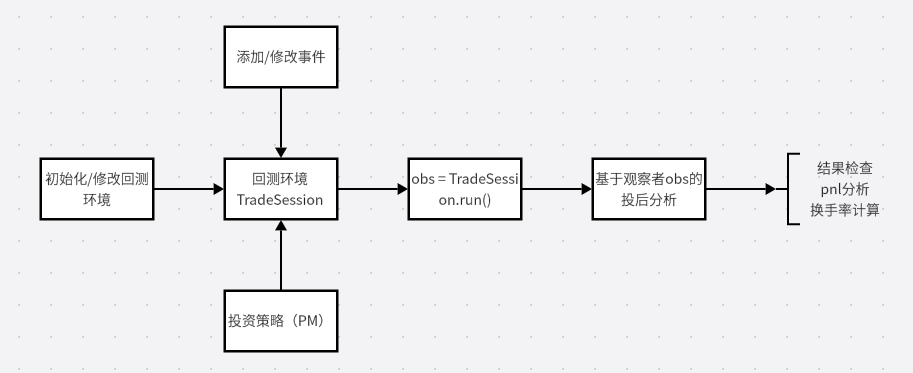

# 事件

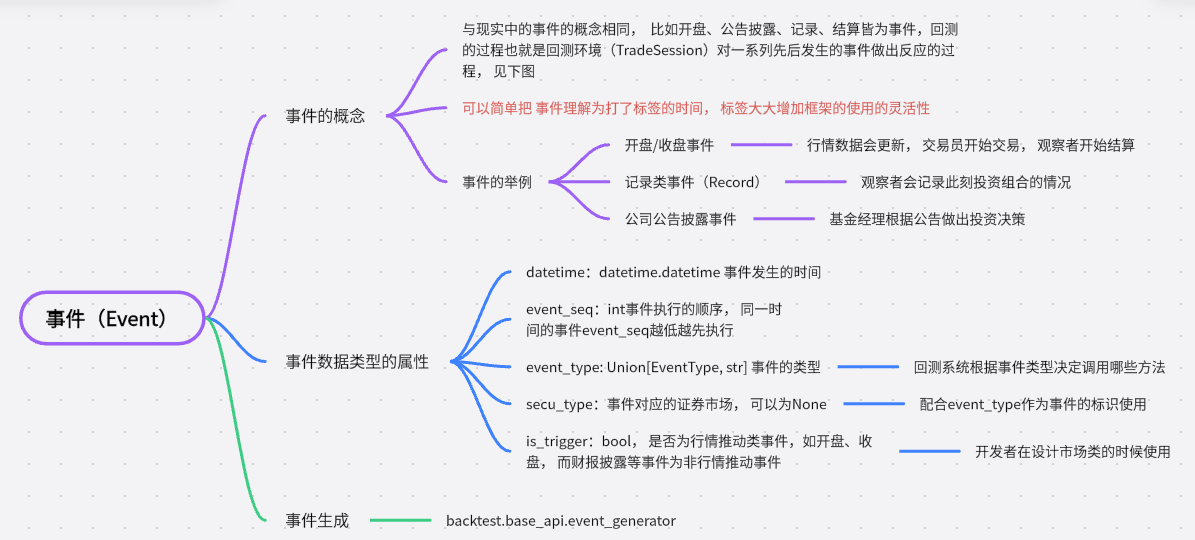

## 回测环境与事件的交互

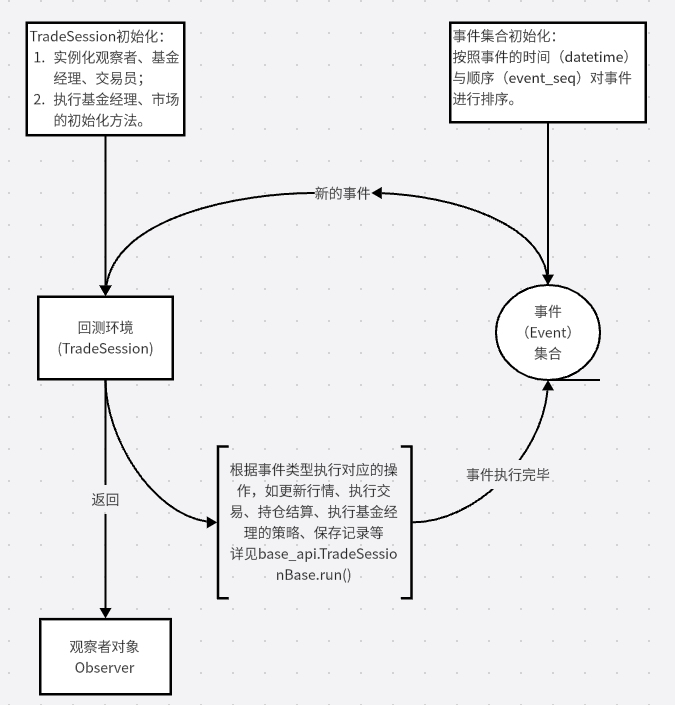

## 事件生成例

In [3]:
# 生成any类事件
t_series = pd.date_range('2021-01-01', '2021-03-01', freq='w')
events = event_generator(t_series.to_pydatetime(), event_type='any')
events[0]

Event(datetime=datetime.datetime(2021, 1, 3, 0, 0), event_seq=5, event_type='any', is_trigger=False, secu_type=None)

# 初始化/修改回测环境

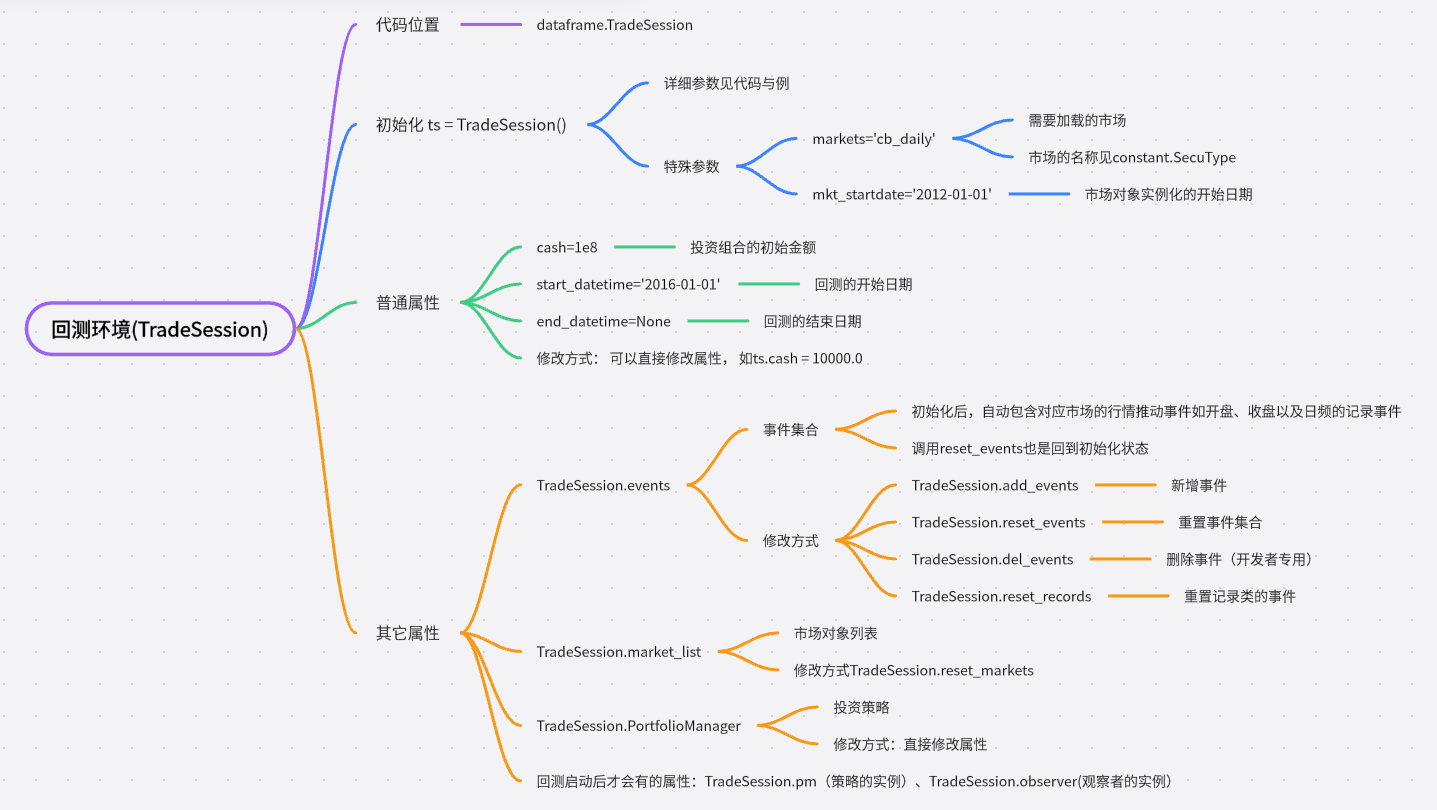

## 初始化

In [4]:
ts = TradeSession(
    # PortfolioManager=None,  # 基金经理（策略）
    # cash=1e8,  # 默认初始金额为一亿
    # start_datetime="2016-01-01",  # 回测的开始日期
    # end_datetime=None,  # 回测的结束日期
    # markets="cb_daily",  # 回测所需的市场对象
    # mkt_startdate="2012-01-01",  # 市场对象实例化的开始日期
) 

## 属性

In [5]:
type(ts.events), type(next(iter(ts.events))), next(iter(ts.events))

(set,
 backtest.base_api.Event,
 Event(datetime=datetime.datetime(2020, 2, 6, 15, 0), event_seq=0, event_type=<EventType.CLOSE: 'close'>, is_trigger=True, secu_type=<SecuType.CBDAILY: 'cb_daily'>))

In [6]:
type(ts.market_list), type(ts.market_list[0]) 

(list, backtest.dataframe.cb_daily.CBMarket)

## 普通属性修改

In [7]:
print(ts.start_datetime)
print(ts.end_datetime)
print(ts.PortfolioManager)
print(ts.cash)

2016-01-01 00:00:00
2023-10-11 17:27:52.281200
None
100000000.0


In [8]:
ts.start_datetime = '2021-01-01'# 更改回测开始时间
ts.end_datetime = '2021-12-31' # 更改回测结束时间
ts.PortfolioManager = '策略2'  # 更改策略， 实际运行需要更改为PMPandas类
ts.cash = 1e10 # 更改初始资金大小

In [9]:
print(ts.start_datetime)
print(ts.end_datetime)
print(ts.PortfolioManager)
print(ts.cash)

2021-01-01 00:00:00
2022-01-01 00:00:00
策略2
10000000000.0


## 事件的修改

In [10]:
pd.DataFrame(ts.events)['event_type'].value_counts()

EventType.CLOSE     2754
EventType.OPEN      2754
EventType.RECORD    1784
Name: event_type, dtype: int64

### 增加

In [11]:
ts.add_events(events)
pd.DataFrame(ts.events)['event_type'].value_counts()

EventType.CLOSE     2754
EventType.OPEN      2754
EventType.RECORD    1784
any                    9
Name: event_type, dtype: int64

### 重置

In [12]:
ts.reset_events()
pd.DataFrame(ts.events)['event_type'].value_counts()

EventType.CLOSE     2754
EventType.OPEN      2754
EventType.RECORD     243
Name: event_type, dtype: int64

### 重置记录事件

In [13]:
t_series = pd.date_range(ts.start_datetime,ts.end_datetime, freq='w') # 更改为周频
record_events = event_generator(t_series.to_pydatetime(), event_type='record')
ts.reset_records(record_events)
pd.DataFrame(ts.events)['event_type'].value_counts()

EventType.CLOSE     2754
EventType.OPEN      2754
EventType.RECORD      52
Name: event_type, dtype: int64

## 市场的修改

In [14]:
ts.market_list[0], ts.market_list[0].secu_type, ts.market_list[0].data.shape

(<backtest.dataframe.cb_daily.CBMarket at 0x1daf9a9d1f0>,
 <SecuType.CBDAILY: 'cb_daily'>,
 (718555, 9))

In [15]:
ts.reset_markets('cb_daily', '2023-01-01')
ts.market_list[0], ts.market_list[0].secu_type, ts.market_list[0].data.shape

(<backtest.dataframe.cb_daily.CBMarket at 0x1dafbc33dc0>,
 <SecuType.CBDAILY: 'cb_daily'>,
 (65057, 9))

In [16]:
ts.reset_markets('stock_daily', '2023-01-01')
ts.market_list[0], ts.market_list[0].secu_type, ts.market_list[0].data.shape

(<backtest.dataframe.stock_daily.StockMarket at 0x1daf9ab4460>,
 <SecuType.STOCKDAILY: 'stock_daily'>,
 (5316, 13))

In [17]:
ts.reset_markets('cb_daily', '2012-01-01')
ts.market_list[0], ts.market_list[0].secu_type, ts.market_list[0].data.shape

(<backtest.dataframe.cb_daily.CBMarket at 0x1da816babb0>,
 <SecuType.CBDAILY: 'cb_daily'>,
 (718555, 9))

# 投资策略（PM/PortfolioManager)

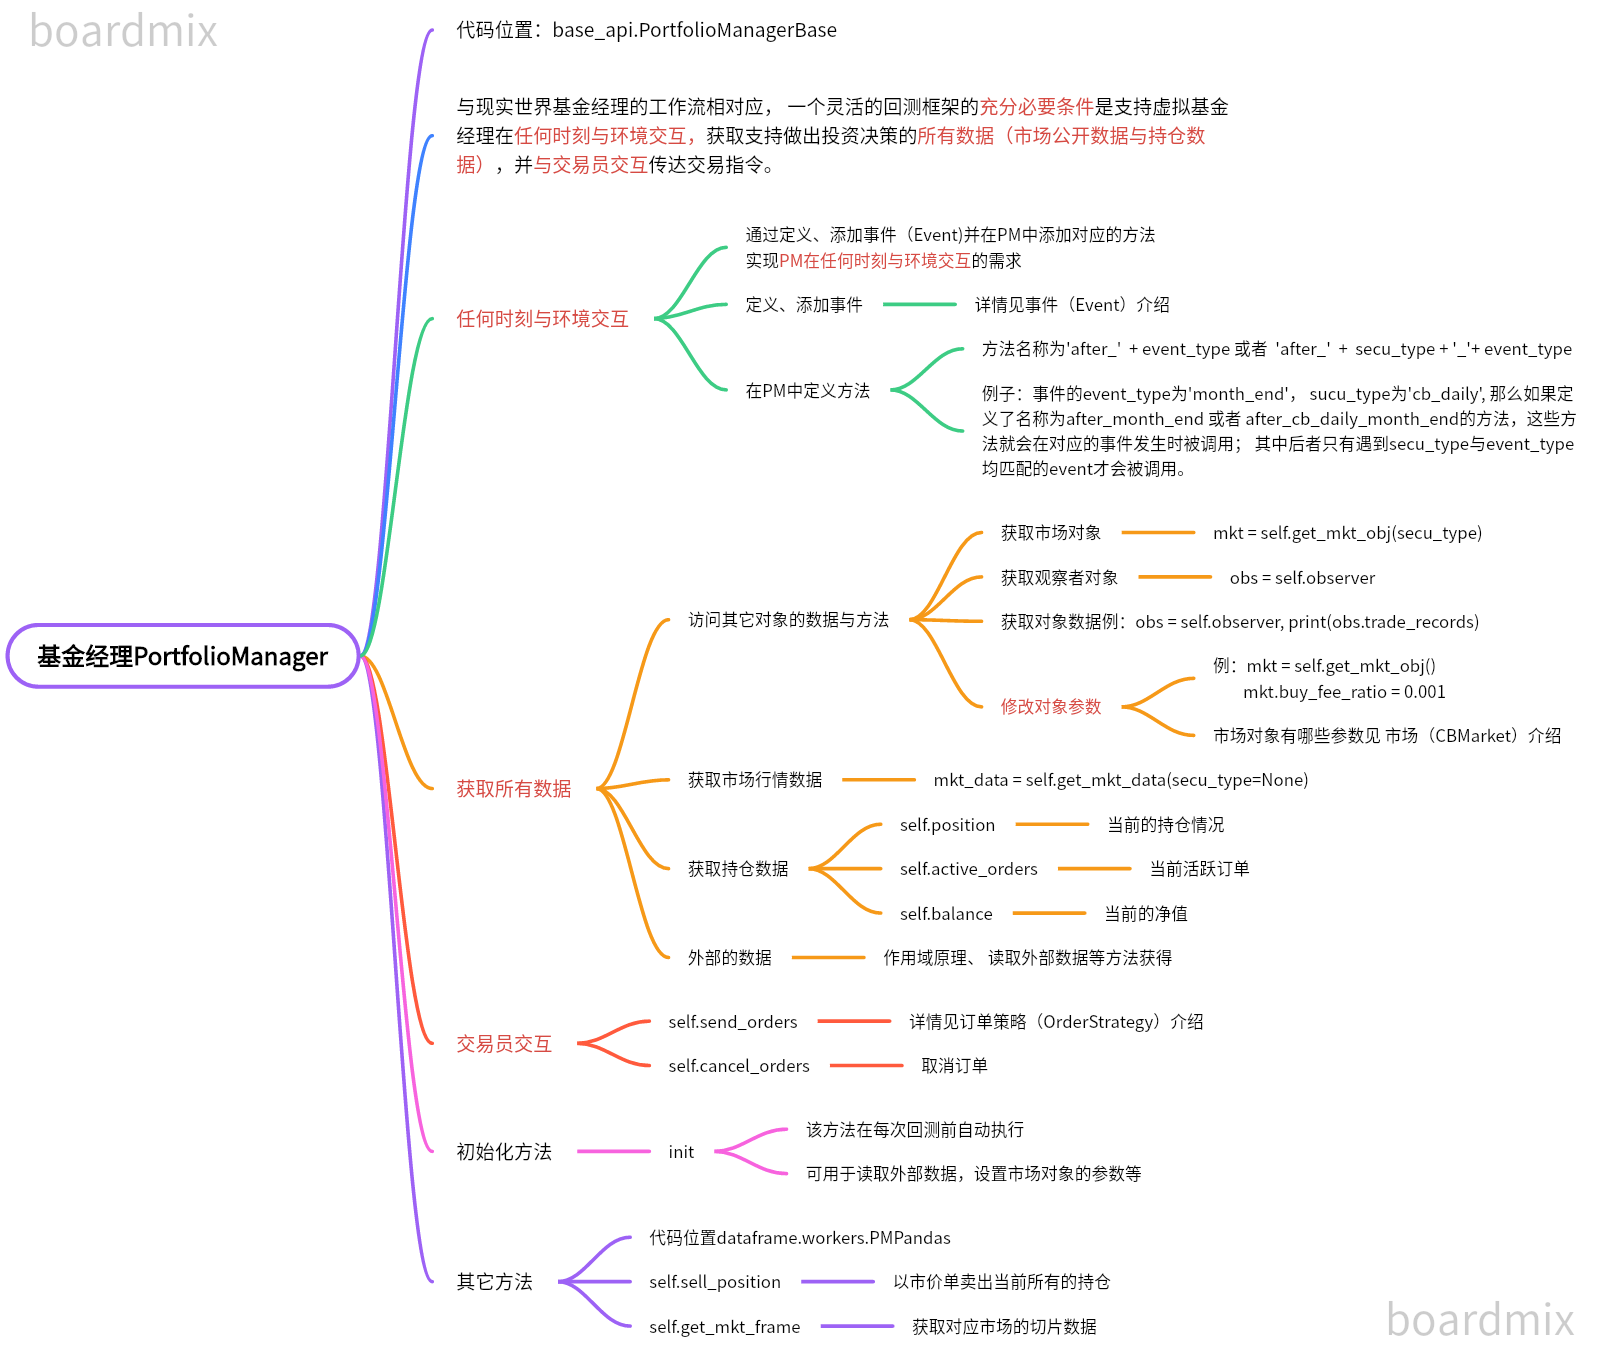

## PM例子

In [18]:
class PMSimple(PMPandas):
    """基金经理（策略）的具体实现"""
    
    def init(self):
        

        # 获取对象 
        obs = self.observer # 获取观察者对象
        print(f'init方法回测前被调用：') 
        mkt = self.get_mkt_obj() # 获取市场对象

        # 修改市场对象的属性
        mkt.sell_fee_ratio = 0.002

        # 获取数据，获取外部数据
        print('数据加载：')
        self.signal = SIGNAL  
        
        # 获取数据： 获取市场数据
        data = self.get_mkt_data()

        # 数据预处理： 粗略计算距离退市的时间
        data['ndelist'] = data.groupby('code', group_keys=False)['tradeDate'].apply(
            lambda x: pd.Series(range(len(x), 0, -1), index=x.index))
        
        # 初始化一个计数的变量
        self.open_count = 0 
        print('-'*10 + '初始化工作完成' + '-'*10)
        
        
    def after_open(self):
        if  self.open_count % 5 == 0:
            print(f'{self.observer.time}开盘了，且self.open_count是5的整数倍，执行买入操作')         
            data = self.get_mkt_frame()
            data = data.sort_values('settlePrice').head(5).query("ndelist > 30")
            data['ratio_relative'] = data['settlePrice'] # 以价格为成交比例
            data['code'] = data.index

            # 与交易员的交互，下单
            self.send_orders(
                data[['code', 'ratio_relative']],
                ratio_to_netasset=0.5,  
                order_type='ratio_market',
                order_seq=1)  # 交易优先级靠后， 保证有足够的资金释放
        self.open_count += 1 
        
    def after_close(self):
        self.cancel_orders(self.active_orders)
        if  (self.open_count+1) % 5 == 0:
            print(f'{self.observer.time}收盘了，触发卖出条件，执行平仓操作') 
            # 与交易员的交互 平仓
            self.sell_position(self.position)

    
    # 通过定义事件与环境交互 
    def after_any(self):
        print(f'{self.observer.time}after_any被调用')

            
    # 通过定义事件与环境交互 
    def after_any_cb_daily(self):
        print(f'{self.observer.time}after_any_cb_daily被调用')
        print('---'*15)
        print("获取数据汇总：")
        print(f"当前时间:{self.observer.time}")
        print(f"当前持仓:{self.position}")
        print(f"当前权益:{self.balance}")
        print(f"当前活跃订单:{self.active_orders}")
        print(f"市场行情:{self.get_mkt_data().tail()}")
        print(f"市场行情切片:{self.get_mkt_frame().tail()}")
        print(f"外部输入的信号:{self.signal}")
        print('---'*15)
            
    def __str__(self):
        return("PM例")

In [19]:
ts.PortfolioManager = PMSimple 
SIGNAL = '某外部数据'

ts.start_datetime = '2021-01-01'
ts.end_datetime = '2021-03-01'
t_series = pd.date_range('2021-01-01', '2021-03-01', freq='w')
events1 = event_generator(t_series[-2:].to_pydatetime(), event_type='any', secu_type='cb_daily', event_seq=0) # 含secu_type
events2 = event_generator(t_series[:-2].to_pydatetime(), event_type='any', event_seq=1)
ts.reset_events()
ts.add_events(events1)
ts.add_events(events2)
obs = ts.run()

init方法回测前被调用：
数据加载：
----------初始化工作完成----------
2021-01-03 00:00:00after_any被调用
2021-01-04 09:30:00开盘了，且self.open_count是5的整数倍，执行买入操作
2021-01-07 15:00:00收盘了，触发卖出条件，执行平仓操作
2021-01-10 00:00:00after_any被调用
2021-01-11 09:30:00开盘了，且self.open_count是5的整数倍，执行买入操作
2021-01-14 15:00:00收盘了，触发卖出条件，执行平仓操作
2021-01-17 00:00:00after_any被调用
2021-01-18 09:30:00开盘了，且self.open_count是5的整数倍，执行买入操作
2021-01-21 15:00:00收盘了，触发卖出条件，执行平仓操作
2021-01-24 00:00:00after_any被调用
2021-01-25 09:30:00开盘了，且self.open_count是5的整数倍，执行买入操作
2021-01-28 15:00:00收盘了，触发卖出条件，执行平仓操作
2021-01-31 00:00:00after_any被调用
2021-02-01 09:30:00开盘了，且self.open_count是5的整数倍，执行买入操作
2021-02-04 15:00:00收盘了，触发卖出条件，执行平仓操作
2021-02-07 00:00:00after_any被调用
2021-02-08 09:30:00开盘了，且self.open_count是5的整数倍，执行买入操作
2021-02-14 00:00:00after_any被调用
2021-02-18 15:00:00收盘了，触发卖出条件，执行平仓操作
2021-02-21 00:00:00after_any被调用
2021-02-21 00:00:00after_any_cb_daily被调用
---------------------------------------------
获取数据汇总：
当前时间:2021-02-21 00:00:00
当前持仓:Empty DataFrame
Columns: [order

## 交易接口详解

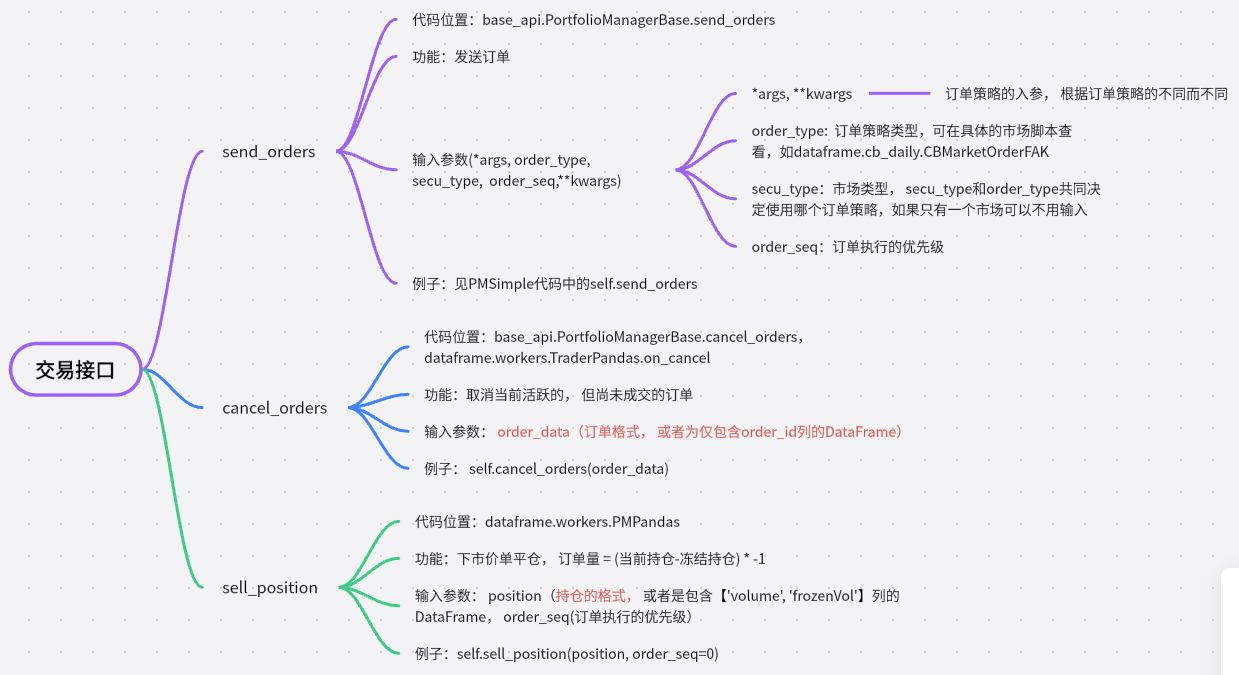

## 订单策略详解

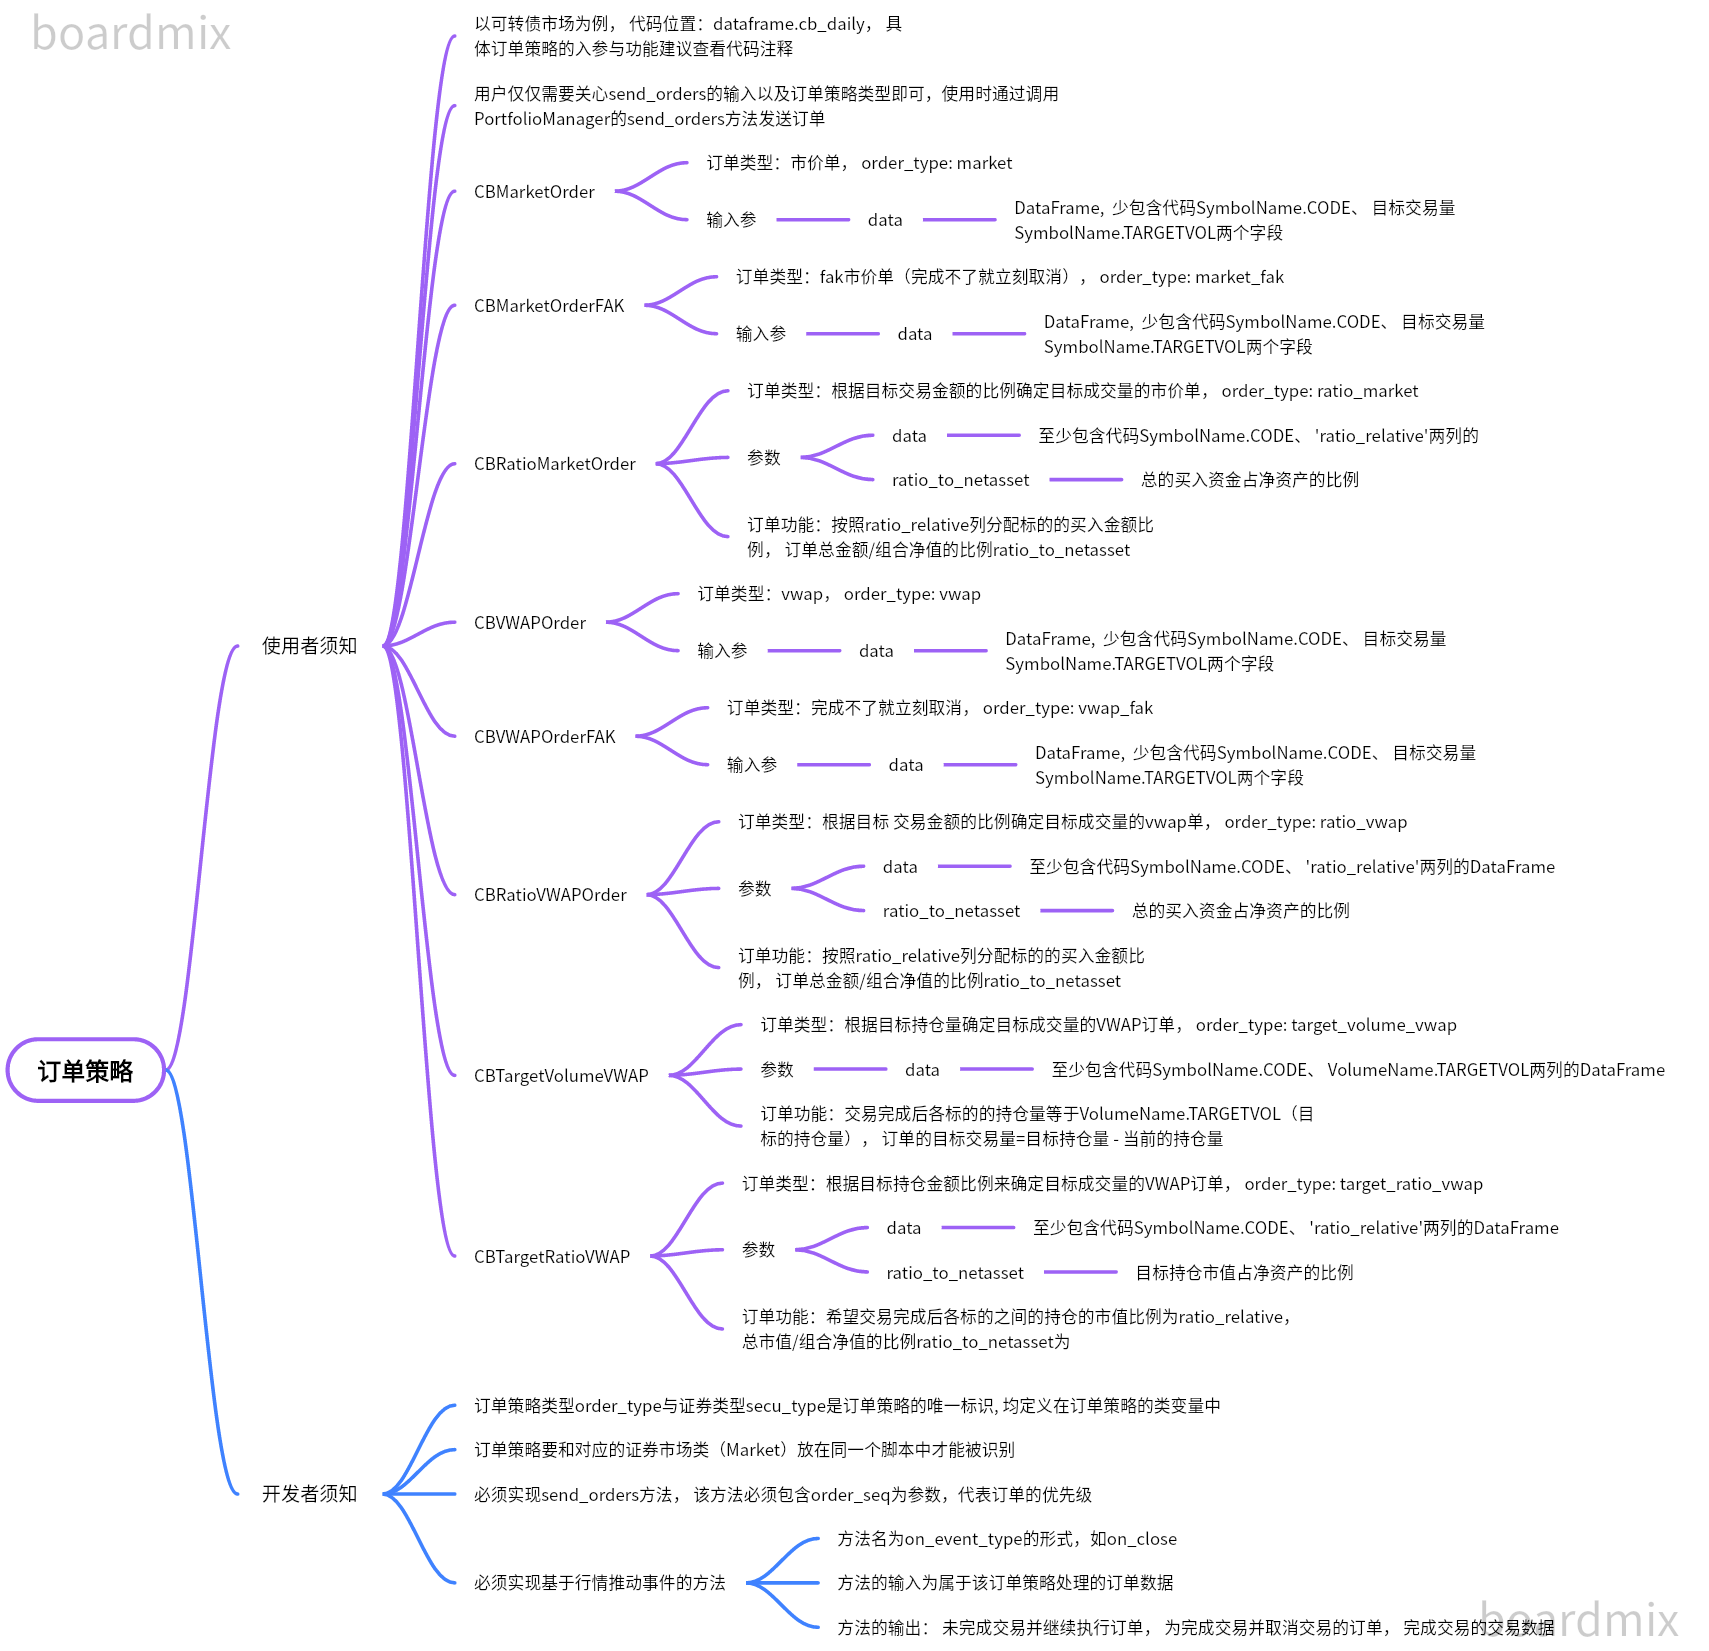

# 投后分析

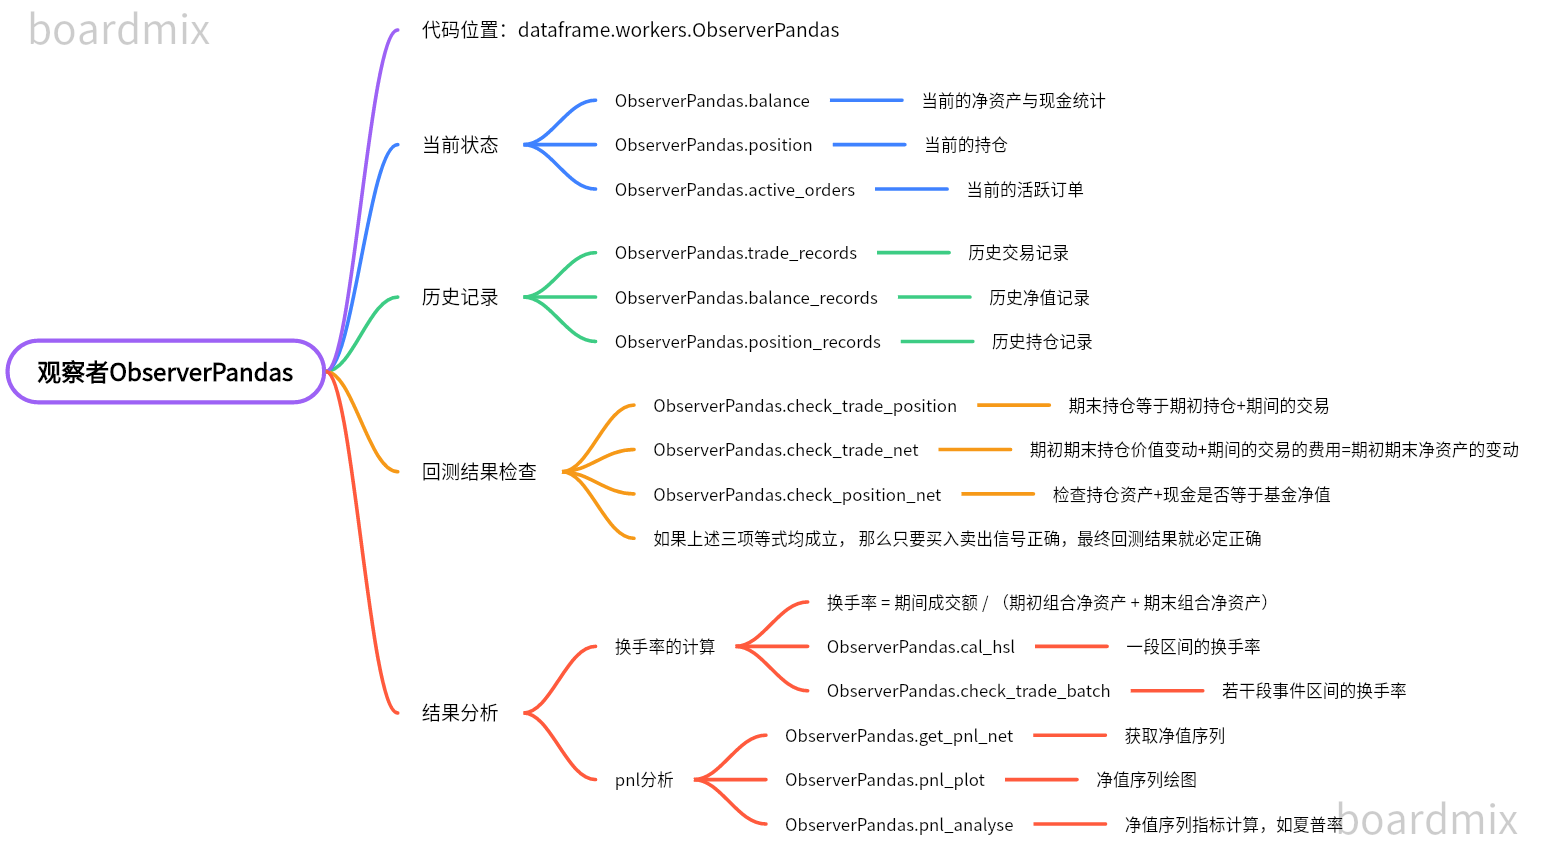

## 当前状态

In [20]:
obs.time

datetime.datetime(2021, 3, 1, 20, 0)

In [21]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,70,70,cb_daily,128062.SZ,2021-03-01 15:00:00,72.4695,72.4695,1.256218e+07,-0.0
1,71,71,cb_daily,128100.SZ,2021-03-01 15:00:00,78.6110,78.6110,1.288206e+07,-0.0
2,72,72,cb_daily,127018.SZ,2021-03-01 15:00:00,79.5056,79.5056,1.284870e+07,-0.0
3,73,73,cb_daily,110072.SH,2021-03-01 15:00:00,79.5926,79.5926,1.288152e+07,-0.0
4,74,74,cb_daily,113589.SH,2021-03-01 15:00:00,80.1149,80.1149,1.282063e+07,-0.0


In [22]:
obs.balance

{'netAsset': 9996470422.919657, 'cash': 4999484457.951075, 'frozenCash': 0}

In [23]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq


## 历史记录

In [24]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
70,70,70,cb_daily,128062.SZ,2021-03-01 15:00:00,long,72.4695,1.256218e+07,-1,455187.358862
71,71,71,cb_daily,128100.SZ,2021-03-01 15:00:00,long,78.6110,1.288206e+07,-1,506335.620387
72,72,72,cb_daily,127018.SZ,2021-03-01 15:00:00,long,79.5056,1.284870e+07,-1,510771.654098
73,73,73,cb_daily,110072.SH,2021-03-01 15:00:00,long,79.5926,1.288152e+07,-1,512636.789865
74,74,74,cb_daily,113589.SH,2021-03-01 15:00:00,long,80.1149,1.282063e+07,-1,513561.559272


In [25]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
31,2021-02-23 20:00:00,1.007213e+10,5.066035e+09,0.0,2021-02-23
32,2021-02-24 20:00:00,1.004358e+10,5.066035e+09,0.0,2021-02-24
33,2021-02-25 20:00:00,1.002619e+10,5.066035e+09,0.0,2021-02-25
34,2021-02-26 20:00:00,9.998969e+09,9.998969e+09,0.0,2021-02-26
35,2021-03-01 20:00:00,9.996470e+09,4.999484e+09,0.0,2021-03-01


In [26]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2021-01-04 20:00:00,0,0,cb_daily,128062.SZ,2021-01-04 15:00:00,68.1212,68.1212,1.265232e+07,-0.0,2021-01-04,8.618916e+08
1,2021-01-04 20:00:00,1,1,cb_daily,127018.SZ,2021-01-04 15:00:00,79.3167,79.3167,1.267537e+07,-0.0,2021-01-04,1.005369e+09
2,2021-01-04 20:00:00,2,2,cb_daily,128085.SZ,2021-01-04 15:00:00,82.2671,82.2671,1.245294e+07,-0.0,2021-01-04,1.024467e+09
3,2021-01-04 20:00:00,3,3,cb_daily,113527.SH,2021-01-04 15:00:00,81.6564,81.6564,1.273811e+07,-0.0,2021-01-04,1.040148e+09
4,2021-01-04 20:00:00,4,4,cb_daily,127019.SZ,2021-01-04 15:00:00,83.2750,83.2750,1.279647e+07,-0.0,2021-01-04,1.065626e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
140,2021-03-01 20:00:00,70,70,cb_daily,128062.SZ,2021-03-01 15:00:00,72.4695,72.4695,1.256218e+07,-0.0,2021-03-01,9.103747e+08
141,2021-03-01 20:00:00,71,71,cb_daily,128100.SZ,2021-03-01 15:00:00,78.6110,78.6110,1.288206e+07,-0.0,2021-03-01,1.012671e+09
142,2021-03-01 20:00:00,72,72,cb_daily,127018.SZ,2021-03-01 15:00:00,79.5056,79.5056,1.284870e+07,-0.0,2021-03-01,1.021543e+09
143,2021-03-01 20:00:00,73,73,cb_daily,110072.SH,2021-03-01 15:00:00,79.5926,79.5926,1.288152e+07,-0.0,2021-03-01,1.025274e+09


## 回测检查

持仓资产+现金等于基金净值

In [27]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2021-01-04 20:00:00,9.997501e+09,5.000000e+09,4.997501e+09,9.997501e+09
2021-01-05 20:00:00,9.969393e+09,5.000000e+09,4.969393e+09,9.969393e+09
2021-01-06 20:00:00,9.959575e+09,5.000000e+09,4.959575e+09,9.959575e+09
2021-01-07 20:00:00,9.902163e+09,5.000000e+09,4.902163e+09,9.902163e+09
2021-01-08 20:00:00,9.878720e+09,9.878720e+09,NaN,9.878720e+09
2021-01-11 20:00:00,9.876252e+09,4.939360e+09,4.936892e+09,9.876252e+09
2021-01-12 20:00:00,9.829695e+09,4.939360e+09,4.890335e+09,9.829695e+09
2021-01-13 20:00:00,9.776548e+09,4.939360e+09,4.837188e+09,9.776548e+09
2021-01-14 20:00:00,1.005495e+10,4.939360e+09,5.115588e+09,1.005495e+10


期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [28]:
obs.check_trade_net()

{'nav_end': 9996470422.919657,
 'nav_start': 9997501249.375313,
 'trade_amount': -87358771.36743093,
 'trade_cost': 87874313.41636083,
 'pv_end': 4996985964.968586,
 'pv_start': 4997501249.375312,
 'nav_end_cal': 9996470422.919659}

期末持仓等于期初持仓+期间的交易

In [29]:
obs.check_trade_position()

volume_start  volume_trade    volume_end  volume_net
secuType code                                                           
cb_daily 113527.SH  1.273811e+07 -1.273811e+07           NaN         0.0
         127018.SZ  1.267537e+07  1.733214e+05  1.284870e+07         0.0
         127019.SZ  1.279647e+07 -1.279647e+07           NaN         0.0
         128062.SZ  1.265232e+07 -9.014744e+04  1.256218e+07         0.0
         128085.SZ  1.245294e+07 -1.245294e+07           NaN         0.0
         110072.SH           NaN  1.288152e+07  1.288152e+07         0.0
         113589.SH           NaN  1.282063e+07  1.282063e+07         0.0
         128100.SZ           NaN  1.288206e+07  1.288206e+07         0.0

## 投后分析

### pnl分析

In [30]:
benchmark = pd.read_pickle('./test/data/index300.pkl ')

In [31]:
obs.pnl_analyse(freq='week', benchmark=benchmark,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,0.011920,0.080063,0.07365,0.013518,1.087077,1.278225
benchmark,-0.042332,-0.245088,0.27920,0.093827,-0.877824,NaN


In [32]:
obs.get_pnl_net(benchmark=benchmark, freq='week')

,netAsset,benchmark
2021-01-10,9.878720e+09,5495.4306
2021-01-17,1.008539e+10,5458.0812
2021-01-24,1.010604e+10,5569.7760
2021-01-31,1.002414e+10,5351.9646
2021-02-07,9.969425e+09,5483.4140
2021-02-14,1.002681e+10,5807.7191
2021-02-21,1.013207e+10,5778.8420
2021-02-28,9.998969e+09,5336.7609
2021-03-07,9.996470e+09,5262.7958


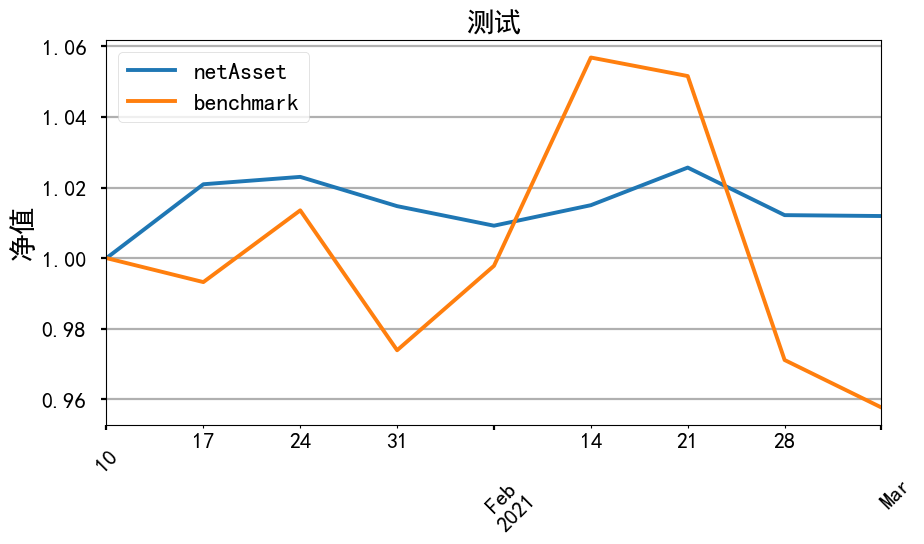

In [33]:
obs.pnl_plot(title='测试',benchmark=benchmark, freq='week')

In [34]:
obs.cal_hsl( include_trade_cost=False)

{'start_record_time': Timestamp('2021-01-04 20:00:00'),
 'end_record_time': Timestamp('2021-03-01 20:00:00'),
 'nav_end': 9996470422.919657,
 'nav_start': 9997501249.375313,
 'trade_amount': 70247035470.26822,
 'trade_cost': 87874313.41636083,
 'hsl': 3.5134107730885393}

### 换手率计算

In [35]:
date_weekend = pd.date_range('2021-01-01', '2021-03-01', freq='w')
t_start = date_weekend
t_end = date_weekend + pd.offsets.Day(7+2)
[*zip(t_start, t_end)][:5]

[(Timestamp('2021-01-03 00:00:00', freq='W-SUN'),
  Timestamp('2021-01-12 00:00:00')),
 (Timestamp('2021-01-10 00:00:00', freq='W-SUN'),
  Timestamp('2021-01-19 00:00:00')),
 (Timestamp('2021-01-17 00:00:00', freq='W-SUN'),
  Timestamp('2021-01-26 00:00:00')),
 (Timestamp('2021-01-24 00:00:00', freq='W-SUN'),
  Timestamp('2021-02-02 00:00:00')),
 (Timestamp('2021-01-31 00:00:00', freq='W-SUN'),
  Timestamp('2021-02-09 00:00:00'))]

In [36]:
date_weekend = pd.date_range(start='2017', end='2024', freq='w')
hsl = obs.cal_hsl_batch(t_start, t_end, include_trade_cost=False)
hsl.tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
4,2021-02-01 20:00:00,2021-02-08 20:00:00,9.966934e+09,1.002163e+10,9.949512e+09,1.242569e+07,0.498382
5,2021-02-08 20:00:00,2021-02-10 20:00:00,1.002681e+10,9.966934e+09,0.000000e+00,0.000000e+00,0.000000
6,2021-02-18 20:00:00,2021-02-22 20:00:00,1.012954e+10,1.014214e+10,1.022118e+10,1.284710e+07,0.504843
7,2021-02-22 20:00:00,2021-03-01 20:00:00,9.996470e+09,1.012954e+10,9.939806e+09,1.238413e+07,0.494494
8,2021-03-01 20:00:00,2021-03-01 20:00:00,9.996470e+09,9.996470e+09,0.000000e+00,0.000000e+00,0.000000


# 市场类介绍

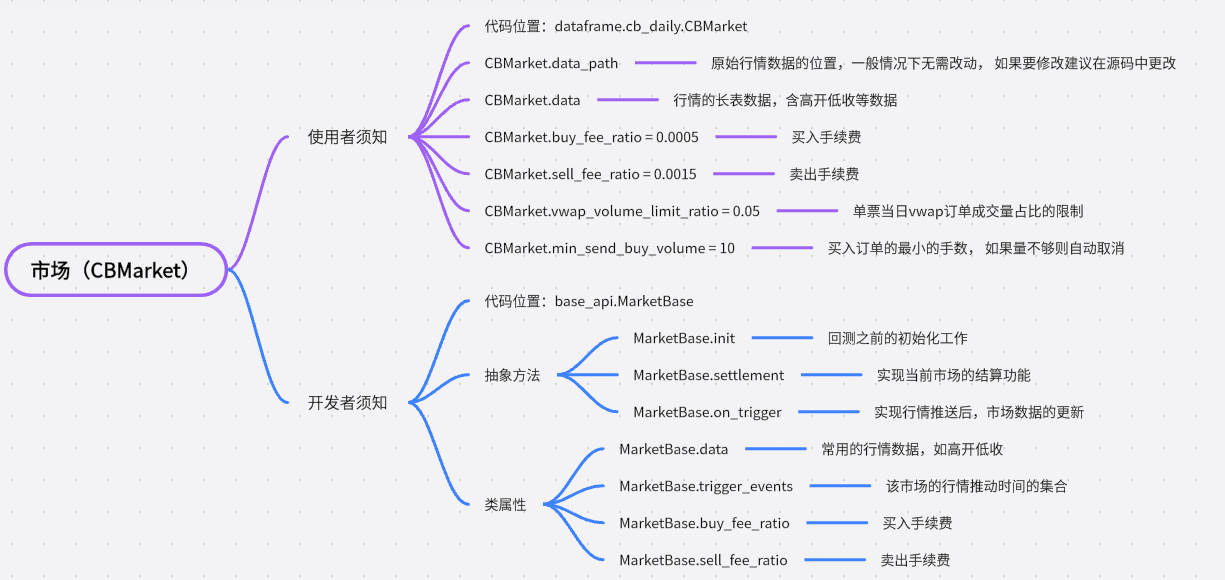

# 数据格式规范

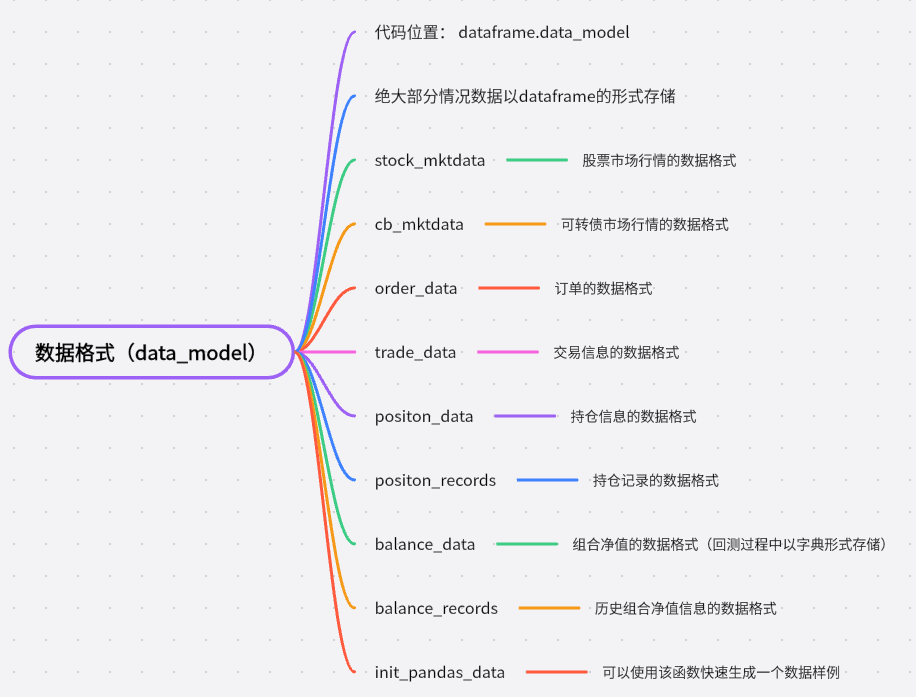

In [37]:
data_model.init_pandas_data(data_model.CB_MKTDATA)

,code,tradeDate,openAdj,highAdj,lowAdj,closeAdj,vwapAdj,volume,amount


In [38]:
data_model.init_pandas_data(data_model.BALANCE_RECORDS)

,recordTime,netAsset,cash,frozenCash


# 回测过程中的参与者

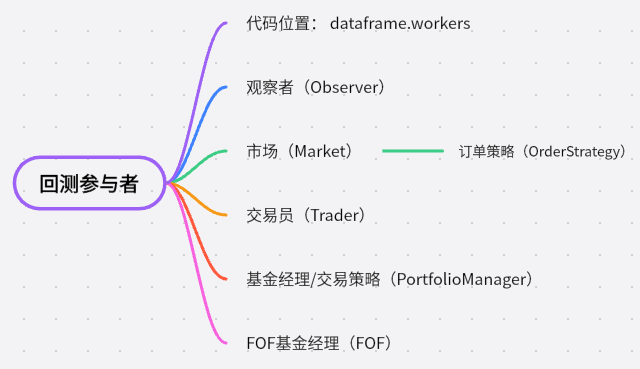